---
## Análisis de Rentabilidad y Comportamiento de Clientes para una Tienda de Retail Online

> 💡 *Este notebook es parte de un ejercicio práctico de análisis de datos orientado a desarrollar habilidades en exploración, limpieza y visualización de datos y análisis de negocio en contextos similares a un caso reales.*

Como parte del equipo de análisis de una tienda de retail online con un catálogo diverso de productos, nuestro objetivo principal es proporcionar al equipo directivo **información estratégica** que les permita tomar decisiones fundamentadas. Nos centraremos en responder las siguientes preguntas clave:

* **¿Qué tipo de productos son más rentables?**  
  Identificaremos las categorías y productos individuales que generan los mayores márgenes de ganancia.

* **¿Qué clientes deberían ser prioridad para campañas de fidelización?**  
  Clasificaremos a los clientes según su valor y potencial de retención.

* **¿Cómo se comportan los clientes en cuanto a frecuencia y monto de compra?**  
  Analizaremos los patrones de compra para entender mejor el comportamiento del consumidor.

* **¿Hay productos o categorías con alta tasa de devolución o baja rentabilidad?**  
  Identificaremos posibles problemas en el inventario o la calidad del producto que impacten la rentabilidad.

---

### Archivos CSV Incluidos:

Para llevar a cabo este análisis, utilizaremos los siguientes archivos CSV, que contienen datos del último año:

#### `orders.csv`  
Contiene información detallada sobre todos los pedidos realizados:
- `order_id` (str): Identificador único del pedido.  
- `customer_id` (str): Identificador único del cliente que realizó el pedido.  
- `order_date` (datetime): Fecha en que se realizó el pedido.  
- `order_status` (str): Estado actual del pedido (ej. "Completed", "Cancelled", "Returned").  
- `shipping_cost` (float): Costo de envío asociado al pedido.  
- `payment_method` (str): Método de pago utilizado.  
- `total_amount` (float): Monto total del pedido.  

#### `order_items.csv`  
Desglosa los productos incluidos en cada pedido:
- `order_id` (str): Identificador del pedido al que pertenece el ítem.  
- `product_id` (str): Identificador único del producto.  
- `category` (str): Categoría del producto (ej. "Ropa", "Electrónicos").  
- `product_name` (str): Nombre del producto.  
- `quantity` (int): Cantidad del producto comprado en el pedido.  
- `unit_price` (float): Precio unitario del producto en el momento de la compra.  
- `discount` (float): Porcentaje de descuento aplicado al producto (ej. 0.10 para un 10%).  

#### `customers.csv`  
Contiene información relevante sobre cada cliente:
- `customer_id` (str): Identificador único del cliente.  
- `name` (str): Nombre completo del cliente.  
- `email` (str): Dirección de correo electrónico del cliente.  
- `signup_date` (datetime): Fecha de registro del cliente.  
- `country` (str): País de residencia del cliente.  

#### `products.csv`  
Proporciona información general sobre los productos disponibles:
- `product_id` (str): Identificador único del producto.  
- `category` (str): Categoría del producto.  
- `product_name` (str): Nombre del producto.  
- `cost_price` (float): Precio de costo del producto para la tienda.  
- `supplier` (str): Proveedor del producto.  

---

➡️ A partir de estos datos, construiremos métricas clave, visualizaciones interactivas y recomendaciones accionables para mejorar la rentabilidad y la relación con los clientes.


In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

import plotly.express as px
import plotly.graph_objects as go


In [65]:
# --- 1. Cargar y Preparar Datos ---
# Cargar los CSVs
clientes = pd.read_csv("customers.csv")
orders_items = pd.read_csv("order_items.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")

In [66]:

display(clientes.head())
display(orders_items.head())
display(orders.head())
display(products.head())

,customer_id,name,email,signup_date,country
0,CUST0000,Customer_0,user0@example.com,2022-04-13,Colombia
1,CUST0001,Customer_1,user1@example.com,2023-03-12,Mexico
2,CUST0002,Customer_2,user2@example.com,2022-09-28,Mexico
3,CUST0003,Customer_3,user3@example.com,2022-04-17,Mexico
4,CUST0004,Customer_4,user4@example.com,2022-03-13,Colombia


,order_id,product_id,category,product_name,quantity,unit_price,discount
0,ORD00001,PROD1238,Books,Books_Product_39,3,41.94,10
1,ORD00001,PROD1164,Toys,Toys_Product_2,3,121.19,5
2,ORD00001,PROD1235,Books,Books_Product_36,2,118.18,15
3,ORD00002,PROD1219,Books,Books_Product_20,2,27.19,15
4,ORD00003,PROD1073,Clothing,Clothing_Product_23,1,70.06,5


,order_id,customer_id,order_date,order_status,shipping_cost,payment_method,total_amount
0,ORD00000,CUST0176,2023-01-07,Cancelled,10.23,Bank Transfer,0.00
1,ORD00001,CUST0195,2023-05-25,Completed,4.00,PayPal,663.54
2,ORD00002,CUST0142,2023-07-30,Completed,4.97,Credit Card,51.19
3,ORD00003,CUST0078,2023-02-16,Completed,14.37,Credit Card,327.77
4,ORD00004,CUST0088,2023-04-22,Completed,11.59,Credit Card,398.77


,product_id,category,product_name,cost_price,supplier
0,PROD1000,Electronics,Electronics_Product_0,51.13,Supplier_3
1,PROD1001,Electronics,Electronics_Product_1,66.94,Supplier_9
2,PROD1002,Electronics,Electronics_Product_2,21.71,Supplier_4
3,PROD1003,Electronics,Electronics_Product_3,27.54,Supplier_5
4,PROD1004,Electronics,Electronics_Product_4,21.99,Supplier_8


In [67]:
# Convertir columnas de fecha a datetime
orders['order_date'] = pd.to_datetime(orders['order_date'])
clientes['signup_date'] = pd.to_datetime(clientes['signup_date'])

# Unir DataFrames para un análisis completo de los ítems de pedido
# orders_items + products para tener el costo por producto
order_details = pd.merge(orders_items, products, on=['product_id', 'category', 'product_name'], how='left')

# order_details + orders para tener el status del pedido y el costo de envío (aunque este último no lo usaremos por item)
full_order_details = pd.merge(order_details, orders, on='order_id', how='left')

# ¿Qué tipo de productos son más rentables por categoría?

**Si bien la categoría 'Clothing', es la que provee mas ganancia bruta tiene, respecto al margen de ganancia es levemente mayor la categoría 'Home'.**

In [68]:


# Calcular el precio de venta real por ítem (considerando el descuento)
full_order_details['real_unit_price'] = full_order_details['unit_price'] \
* (1 - full_order_details['discount'] / 100)
full_order_details['item_total_price'] = full_order_details['real_unit_price'] * \
full_order_details['quantity']

# Calcular el costo total por ítem
full_order_details['item_total_cost'] = full_order_details['cost_price']\
 * full_order_details['quantity']

# Calcular la ganancia bruta por ítem
full_order_details['item_gross_profit'] = full_order_details['item_total_price'] - \
full_order_details['item_total_cost']

# Filtrar solo pedidos 'Completed' para análisis de rentabilidad y RFM, a menos que se especifique lo contrario para devoluciones
completed_orders = full_order_details[full_order_details['order_status'] == 'Completed'].copy()

# --- 2. Análisis de Rentabilidad de Productos y Categorías ---

print("--- Análisis de Rentabilidad ---")

# Rentabilidad por Categoría
category_profit = completed_orders.groupby('category').agg(
    total_revenue=('item_total_price', 'sum'),
    total_cost=('item_total_cost', 'sum'),
    total_gross_profit=('item_gross_profit', 'sum')
).reset_index()
category_profit['gross_profit_margin'] = (category_profit['total_gross_profit'] / category_profit['total_revenue']) * 100
category_profit = category_profit.sort_values(by='total_gross_profit', ascending=False)

print("\nTop 5 Categorías por Ganancia Bruta Total:")
print(category_profit.head())

--- Análisis de Rentabilidad ---

Top 5 Categorías por Ganancia Bruta Total:
      category  total_revenue  total_cost  total_gross_profit  \
1     Clothing    137393.9655    89073.52          48320.4455   
3         Home    102868.6490    66308.00          36560.6490   
2  Electronics     96084.0180    63623.44          32460.5780   
0        Books     90375.5660    59183.62          31191.9460   
4         Toys     80482.8485    53371.92          27110.9285   

   gross_profit_margin  
1            35.169263  
3            35.541100  
2            33.783535  
0            34.513694  
4            33.685349  


In [32]:
fig = px.bar(
    category_profit,
    y='total_gross_profit',
    x='category',
    orientation='v',
    text='total_gross_profit',
    title='Margen de ganancia total por categoría',
    labels={'profit_margin': 'Margen ($)', 'category': 'Categoría'},
    color='category',
    color_discrete_sequence=px.colors.sequential.Viridis
)

# Formatear texto
fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside')

In [51]:

# Rentabilidad por Producto (Top 10)
product_profit = completed_orders.groupby(['product_name', 'category']).agg(
    total_revenue=('item_total_price', 'sum'),
    total_cost=('item_total_cost', 'sum'),
    total_gross_profit=('item_gross_profit', 'sum')
).reset_index()

# Rentabilidad por Producto (Top 10)
product_profit['gross_profit_margin'] = (product_profit['total_gross_profit'] / product_profit['total_revenue'])
product_profit['gross_profit_margin'] = product_profit['gross_profit_margin'].map('{:.1%}'.format)
product_profit = product_profit.sort_values(by='gross_profit_margin', ascending=False)
product_profit["ranking_margin"]=[i+1 for i in range(len(product_profit))]
product_profit = product_profit.sort_values(by='total_gross_profit', ascending=False)
product_profit["ranking_gross_profit"]=[i+1 for i in range(len(product_profit))]
print("\nTop 10 Productos por Ganancia Bruta Total:")
print(product_profit.head(10))


Top 10 Productos por Ganancia Bruta Total:
               product_name     category  total_revenue  total_cost  \
216         Toys_Product_12         Toys      6907.8005     4548.00   
107     Clothing_Product_60     Clothing      6199.7825     4040.22   
111      Clothing_Product_9     Clothing      6556.6250     4408.13   
174          Home_Product_2         Home      5823.3580     3880.80   
247          Toys_Product_8         Toys      5687.8295     3747.45   
162          Home_Product_0         Home      4805.0105     3087.91   
35         Books_Product_40        Books      4640.3595     2939.85   
125  Electronics_Product_20  Electronics      4579.3890     2943.90   
243          Toys_Product_4         Toys      4536.3240     2914.20   
97      Clothing_Product_51     Clothing      4366.0840     2755.83   

     total_gross_profit gross_profit_margin  ranking_margin  \
216           2359.8005               34.2%             150   
107           2159.5625               34.8%     

In [60]:
import plotly.express as px

# Asegurarte de que están ordenados correctamente
df_plot = product_profit.sort_values(by='total_gross_profit', ascending=False).head(10)

fig = px.bar(
    df_plot,
    x='total_gross_profit',
    y='product_name',
    orientation='h',
    color='category',
    text='gross_profit_margin',
    title='Top 10 Productos por Ganancia Bruta Total',
    labels={
        'total_gross_profit': 'Ganancia Bruta ($)',
        'product_name': 'Producto',
        'category': 'Categoría',
        'gross_profit_margin': 'Margen (%)'
    },
    color_discrete_sequence=px.colors.qualitative.Vivid
)

# Mostrar % en el texto
fig.update_traces(texttemplate='%{text}',textfont=dict(size=9) , textposition='outside')

# Ajustar el diseño
fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},
    xaxis_tickprefix="$",
     width=900,  # más ancho total
    margin=dict(l=120, r=160, t=60, b=40)
)

fig.show()


In [63]:

product_profit = product_profit.sort_values(by='gross_profit_margin', ascending=False)

print("\nTop 10 Productos por Margen de ganancia:")
print(product_profit.head(10))


Top 10 Productos por Margen de ganancia:
               product_name     category  total_revenue  total_cost  \
228         Toys_Product_23         Toys       183.7010      107.20   
34          Books_Product_4        Books       582.3880      343.20   
129  Electronics_Product_24  Electronics      1670.1565      984.30   
128  Electronics_Product_23  Electronics       593.4130      351.10   
69      Clothing_Product_26     Clothing      3183.6735     1894.00   
82      Clothing_Product_38     Clothing       765.3595      457.08   
51       Clothing_Product_1     Clothing      2552.1985     1530.26   
206         Home_Product_49         Home      2001.9700     1205.40   
164         Home_Product_10         Home      1010.1140      608.40   
100     Clothing_Product_54     Clothing      2694.3300     1624.12   

     total_gross_profit gross_profit_margin  ranking_margin  \
228             76.5010               41.6%               1   
34             239.1880               41.1%       

# ¿Qué tipo de productos son más rentables?
Se reportan los 10 productos con mayor ganancia bruta total, en comparación con aquellos con mayor margen de ganancia. También analizamos los de mayor rentabilidad y podemos ver con mayor claridad que los productos más rentables en términos absolutos no son necesariamente los que tienen el mayor margen porcentual. De hecho, la diferencia entre el margen de los productos más rentables y los de mayor margen alcanza aproximadamente un 7%.

# Análisis de rentabilidad:

**Un producto puede generar una gran ganancia bruta total (en $) aún con un margen más bajo, simplemente porque se vende mucho más o tiene un precio de venta mayor.**

**En contraste, los productos con alto margen de ganancia suelen tener costos de producción o adquisición mucho más bajos en relación a su precio de venta, pero eso no garantiza que se vendan en grandes volúmenes ni que generen más utilidad total.Este desbalance es habitual en el comercio minorista y debe tenerse en cuenta para la toma de decisiones estratégicas:**



*   *Si se busca maximizar ganancias absolutas, conviene priorizar productos con alto volumen de ventas, aunque tengan márgenes moderados.*

*   *Si se apunta a optimizar rentabilidad por unidad, los productos con alto margen son clave, especialmente si los costos logísticos o de atención al cliente son elevados*.







# Analisis de clientes
Para responder a las siguientes preguntas:

- **¿Qué clientes deberían ser prioridad para campañas de fidelización?**  
  Clasificaremos a los clientes según su valor y potencial de retención.

- **¿Cómo se comportan los clientes en cuanto a frecuencia y monto de compra?**  
  Analizaremos los patrones de compra para entender mejor el comportamiento del consumidor.

Aplicamos el modelo **RFM (Recency, Frequency, Monetary)**, una técnica ampliamente utilizada en marketing para segmentar clientes según su comportamiento de compra.

---

## 🔍 ¿Qué es el modelo RFM?

- **Recency (Recencia):** ¿Cuánto tiempo ha pasado desde la última compra del cliente?
- **Frequency (Frecuencia):** ¿Con qué frecuencia compra el cliente?
- **Monetary (Valor Monetario):** ¿Cuánto dinero ha gastado el cliente en total?

Esta segmentación permite identificar a los clientes más valiosos y diseñar estrategias diferenciadas para cada grupo, como fidelización, reactivación o premiación.

---

In [69]:
# Calcular la fecha más reciente en los datos de pedidos completados
snapshot_date = orders['order_date'].max() + pd.Timedelta(days=1) # Usamos el día siguiente a la última orden como snapshot

# Calcular RFM
rfm = orders[orders['order_status'] == 'Completed'].groupby('customer_id').agg(
    recency=('order_date', lambda date: (snapshot_date - date.max()).days),
    frequency=('order_id', 'nunique'),
    monetary=('total_amount', 'sum'),
    tenure=('order_date', lambda date: (snapshot_date - date.min()).days)
).reset_index()

# Unir con la información del cliente
rfm = pd.merge(rfm, clientes[['customer_id', 'country', 'signup_date']], on='customer_id', how='left')

print("\nVista previa del DataFrame RFM:")
print(rfm.head())

# Segmentación RFM (ejemplo simple por cuartiles)
rfm['R_score'] = pd.qcut(rfm['recency'], 4, labels=[4, 3, 2, 1]) # 4 = más reciente
rfm['F_score'] = pd.qcut(rfm['frequency'], 4, labels=[1, 2, 3, 4]) # 4 = más frecuente
rfm['M_score'] = pd.qcut(rfm['monetary'], 4, labels=[1, 2, 3, 4]) # 4 = mayor monto
# rfm['T_score'] = pd.qcut(rfm['tenure'], 4, labels=[1, 2, 3, 4]) # 4 = mayor antiguedad


rfm['RFM_score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) \
    + rfm['M_score'].astype(str)##+rfm['T_score'].astype(str)


rfm.head()


Vista previa del DataFrame RFM:
  customer_id  recency  frequency  monetary  tenure   country signup_date
0    CUST0000      190          3   1888.30     222  Colombia  2022-04-13
1    CUST0001       24          3   1265.92     290    Mexico  2023-03-12
2    CUST0002       65          7   2826.36     320    Mexico  2022-09-28
3    CUST0003       59          5   1392.31     306    Mexico  2022-04-17
4    CUST0004      176          5   1945.47     330  Colombia  2022-03-13


,customer_id,recency,frequency,monetary,tenure,country,signup_date,R_score,F_score,M_score,RFM_score
0,CUST0000,190,3,1888.30,222,Colombia,2022-04-13,1,1,3,113
1,CUST0001,24,3,1265.92,290,Mexico,2023-03-12,4,1,2,412
2,CUST0002,65,7,2826.36,320,Mexico,2022-09-28,2,4,4,244
3,CUST0003,59,5,1392.31,306,Mexico,2022-04-17,3,3,2,332
4,CUST0004,176,5,1945.47,330,Colombia,2022-03-13,1,3,3,133


In [70]:
## Segmentación de clientes de acuerdo al potencial

def classify_rfm(score):
    r, f, m = int(score[0]), int(score[1]), int(score[2])

    if r ==4 and f == 1:
       if m>=2:
          return 'Nuevo_alto'
       else:
          return 'Nuevo_bajo'


      # return 'Nuevo'

    elif r>=3 and  f>=3 and m>=3:
      return 'Reciente_alto'

    elif r>=3 and  f<=3 and m<=2:
      return 'Reciente_bajo'

    elif r == 4 and f == 4 and m == 4:
        return 'Campeon'
    elif r>=2 and f >= 3 and m >= 3 :
        return 'Cliente leal'
    elif r <= 2 and m >= 3:
        return 'Cliente en riesgo'
    elif r<=2 and f <= 2 and m <= 2:
        return 'Bajo Potencial'

    elif f <=2 and m >= 3 :
        return 'Buen Potencial'
    elif r <= 2 and m >= 2 and f>=3:
        return 'Perdido'
    else:
        return 'Otro'
rfm['segment'] = rfm['RFM_score'].apply(classify_rfm)
print(rfm['segment'].value_counts())

segment
Bajo Potencial       88
Reciente_alto        73
Reciente_bajo        45
Cliente leal         32
Cliente en riesgo    25
Buen Potencial       18
Nuevo_alto            7
Nuevo_bajo            6
Perdido               4
Otro                  1
Name: count, dtype: int64


### 🧩 Segmentación de Clientes RFM

Luego de calcular los puntajes RFM de cada cliente (Recency, Frequency, Monetary) y aplicar una lógica de clasificación personalizada, obtuvimos la siguiente distribución de clientes por segmento:

| Segmento             | Cantidad de Clientes |
|----------------------|----------------------|
| Bajo Potencial       | 88                   |
| Reciente_alto        | 73                   |
| Reciente_bajo        | 45                   |
| Cliente leal         | 32                   |
| Cliente en riesgo    | 25                   |
| Buen Potencial       | 18                   |
| Nuevo_alto           | 7                    |
| Nuevo_bajo           | 6                    |
| Perdido              | 4                    |
| Otro                 | 1                    |

> 📌 *La segmentación fue realizada utilizando una función de clasificación adaptada(classify_rfm) que permite distinguir matices relevantes de comportamiento, como clientes nuevos con alto o bajo gasto, recientes con distinto nivel de compromiso, y clientes en riesgo o perdidos.*

---

### ✅ Segmentos Clave y Recomendaciones

- 🥇 **Clientes Leales (`Cliente leal`) – 32 clientes**  
  Son clientes con alta frecuencia y alto valor monetario. Representan la **base más sólida del negocio** y deberían ser el foco de **programas de fidelización**, descuentos exclusivos y atención diferenciada.

- 🔥 **Recientes con alto potencial (`Reciente_alto`) – 73 clientes**  
  Han comprado recientemente, con buena frecuencia o monto. Representan una **gran oportunidad de retención**, y son ideales para campañas de seguimiento postventa y recomendaciones personalizadas.

- 🌱 **Buen Potencial (`Buen Potencial`) – 18 clientes**  
  Compran poco frecuentemente, pero gastan mucho. Es conveniente incentivarlos para que vuelvan a comprar más seguido, con promociones o ventas cruzadas.

- 🚨 **Clientes en riesgo (`Cliente en riesgo`) – 25 clientes**  
  Solían ser clientes de alto valor pero no han comprado recientemente. Requieren **acciones urgentes de reactivación**, como campañas con mensajes personalizados, descuentos agresivos o encuestas de satisfacción.

- 🧊 **Clientes perdidos (`Perdido`) – 4 clientes**  
  Han dejado de comprar y tienen historial valioso. Aunque son pocos, podría intentarse una **última reactivación** antes de descartarlos.
  
- **Reciente_bajo – 45 clientes**  
  Compraron recientemente, pero su frecuencia y gasto son bajos. Pueden evolucionar si se les guía con ofertas bien segmentadas.

- **Nuevo_alto / Nuevo_bajo – 13 clientes combinados**  
  Clientes nuevos con compras recientes. Es clave darles una buena primera experiencia y motivarlos a repetir.
---

### ⚠️ Segmentos Menos Prioritarios

- **Bajo Potencial (`Bajo Potencial`) – 88 clientes**  
  Tienen poca frecuencia, bajo gasto y no compran hace tiempo. Es el grupo más numeroso, pero con bajo retorno esperado. No se recomienda destinar esfuerzos de marketing costosos a este grupo.


- **Otro – 1 cliente**  
  No encajó claramente en los criterios anteriores. Puede analizarse individualmente o ignorarse estadísticamente.

---

In [71]:
px.pie(rfm,names="segment")

In [72]:
px.treemap(rfm, path=['country', 'segment'], values='monetary',
           color='segment', title='Treemap Segmento vs País').show()

In [73]:
seg_country_counts = rfm.groupby(['segment', 'country']).size().reset_index(name='count')

# Gráfico de barras apiladas o agrupadas con hue
fig = px.bar(
    seg_country_counts,
    y='segment',
    x='count',
    color='country',  # <-- Esto es el hue
    orientation='h',
    title='Clientes por Segmento y País ',
    text='count',
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig.update_traces(textposition='inside')
fig.update_layout(yaxis={'categoryorder': 'total ascending'})
fig.show()

In [ ]:
rfm.head()

,customer_id,recency,frequency,monetary,tenure,country,signup_date,R_score,F_score,M_score,RFM_score,segment
0,CUST0000,190,3,1888.30,222,Colombia,2022-04-13,1,1,3,113,Cliente en riesgo
1,CUST0001,24,3,1265.92,290,Mexico,2023-03-12,4,1,2,412,Nuevo_alto
2,CUST0002,65,7,2826.36,320,Mexico,2022-09-28,2,4,4,244,Cliente leal
3,CUST0003,59,5,1392.31,306,Mexico,2022-04-17,3,3,2,332,Reciente_bajo
4,CUST0004,176,5,1945.47,330,Colombia,2022-03-13,1,3,3,133,Cliente en riesgo


### 🔥 Heatmap R vs F con Promedio de M

Para visualizar mejor la relación entre las dimensiones **Recency** (R) y **Frequency** (F) y cómo se comporta en promedio el valor monetario (**Monetary**, M), construimos un **heatmap** donde:

- Las filas representan los puntajes de **Recency** (`R_score`), ordenados de mayor a menor (clientes más recientes arriba).
- Las columnas muestran los puntajes de **Frequency** (`F_score`).
- Cada celda contiene el **promedio del puntaje `M_score`** para ese grupo de clientes.

Este tipo de visualización nos permite:

- Identificar combinaciones de **alta frecuencia y alta recencia** que generan **altos valores monetarios**.
- Detectar posibles segmentos de alto valor o zonas donde podrían concentrarse estrategias de marketing.
- Analizar rápidamente si existe correlación entre la recencia/frecuencia y el valor del cliente.

Acá podemos ver rápidamente que los clientes con mayor frecuencia de compra, son los de mas alto valor monetario en promedio.

In [ ]:
# Crear tabla pivote R vs F, valores M (como en sns.heatmap)
pivot_rf = rfm[["R_score","F_score","M_score"]].astype(int).pivot_table(index='R_score', columns='F_score', values='M_score', aggfunc='mean')
# Asegurarse de que los índices estén ordenados correctamente para el heatmap
pivot_rf = pivot_rf.sort_index(ascending=False)  # para que R=4 quede arriba
pivot_rf = pivot_rf.sort_index(axis=1)
# Heatmap con px.imshow
pivot_rf

# Heatmap con px.imshow
fig = px.imshow(
    pivot_rf,

    x=pivot_rf.columns.astype(str),
    y=pivot_rf.index.astype(str),
    text_auto=".1f",         # muestra los valores como texto, 1 decimal
    color_continuous_scale='YlGnBu',
    labels=dict(x="F_score", y="R_score", color="Avg M_score"),
    title='Heatmap, R_score vs F_score (Promedio M_score)'
)

fig.update_layout(yaxis_title='R_score', xaxis_title='F_score')
fig.show()

### Comportamiento de Compra del Cliente, indicadores.

In [74]:
# Frecuencia de compra
order_frequency = orders[orders['order_status'] == 'Completed']\
    .groupby('customer_id')['order_id'].nunique()

print(f"\nFrecuencia promedio de órdenes por cliente: {order_frequency.mean():.2f}")
print(f"Mediana de frecuencia de órdenes por cliente: {order_frequency.median():.2f}")

fig_freq = px.histogram(
    order_frequency,
    nbins=order_frequency.max(),  # una barra por valor
    title='Distribución de la Frecuencia de Compra por Cliente',
    labels={'value': 'Número de Órdenes Completadas', 'count': 'Número de Clientes'},
    color_discrete_sequence=['indigo']
)
fig_freq.update_layout(bargap=0.1)
fig_freq.show()


Frecuencia promedio de órdenes por cliente: 4.31
Mediana de frecuencia de órdenes por cliente: 4.00


In [77]:
# Monto total gastado por cliente
total_spent_per_customer = orders[orders['order_status'] == 'Completed']\
    .groupby('customer_id')['total_amount'].sum()

print(f"\nMonto promedio de gasto por cliente: {total_spent_per_customer.mean():.2f}")
print(f"Mediana del monto de gasto por cliente: {total_spent_per_customer.median():.2f}")
avg_order_value = orders[orders['order_status'] == 'Completed']['total_amount'].mean()
print(f"\nValor promedio de un pedido completado: ${avg_order_value:.2f}")
fig_spent = px.histogram(
    total_spent_per_customer,
    nbins=40,
    title='Distribución del Monto Total Gastado por Cliente',
    labels={'value': 'Monto Total Gastado', 'count': 'Número de Clientes'},
    color_discrete_sequence=['darkorange']
)
fig_spent.update_layout(bargap=0.05)
fig_spent.show()



Monto promedio de gasto por cliente: 1733.42
Mediana del monto de gasto por cliente: 1676.28

Valor promedio de un pedido completado: $401.78



--- Comportamiento de Compra del Cliente ---

Frecuencia promedio de órdenes por cliente: 4.31
Mediana de frecuencia de órdenes por cliente: 4.00


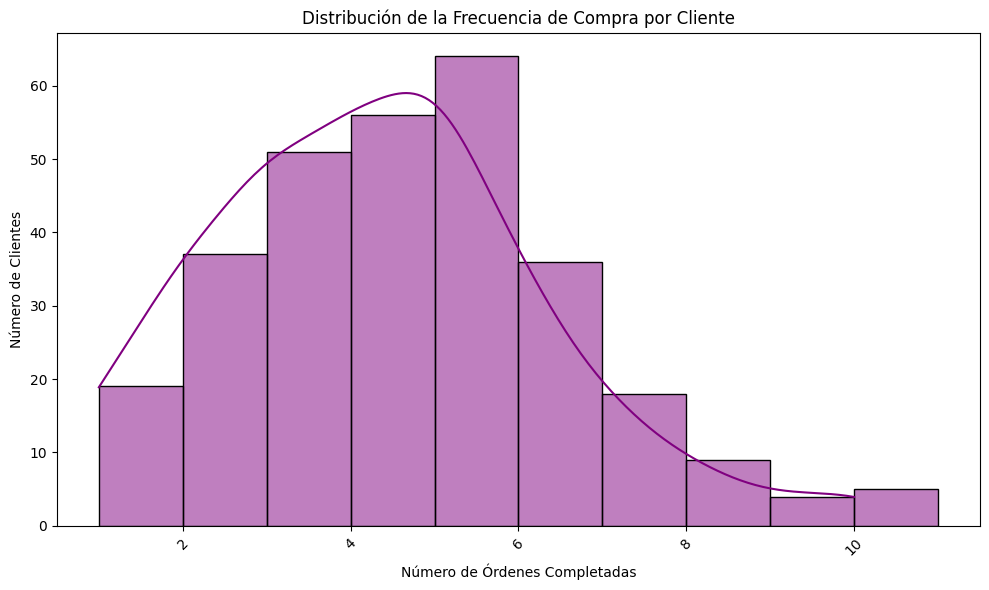


Monto promedio de gasto por cliente: 1733.42
Mediana del monto de gasto por cliente: 1676.28


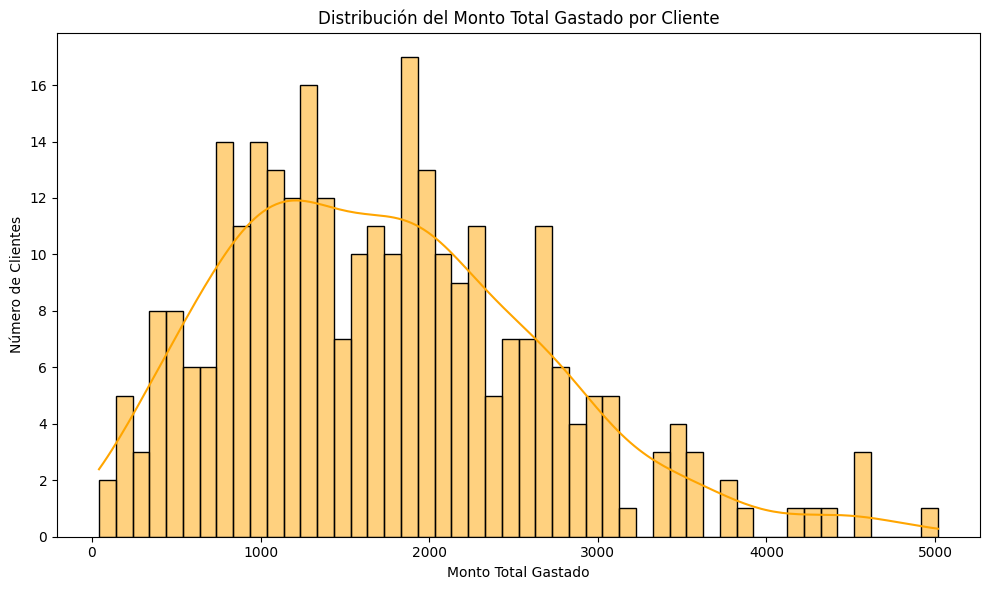


Valor promedio de un pedido completado: $401.78


In [ ]:

print("\n--- Comportamiento de Compra del Cliente ---")

# Frecuencia de Compra
order_frequency = orders[orders['order_status'] == 'Completed']\
.groupby('customer_id')['order_id'].nunique()
print(f"\nFrecuencia promedio de órdenes por cliente: {order_frequency.mean():.2f}")
print(f"Mediana de frecuencia de órdenes por cliente: {order_frequency.median():.2f}")

plt.figure(figsize=(10, 6))
sns.histplot(order_frequency, bins=range(1, order_frequency.max() + 2), kde=True, color='purple')
plt.title('Distribución de la Frecuencia de Compra por Cliente')
plt.xlabel('Número de Órdenes Completadas')
plt.ylabel('Número de Clientes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Monto de Compra
total_spent_per_customer = orders[orders['order_status'] == 'Completed']\
.groupby('customer_id')['total_amount'].sum()
print(f"\nMonto promedio de gasto por cliente: {total_spent_per_customer.mean():.2f}")
print(f"Mediana del monto de gasto por cliente: {total_spent_per_customer.median():.2f}")

plt.figure(figsize=(10, 6))
sns.histplot(total_spent_per_customer, bins=50, kde=True, color='orange')
plt.title('Distribución del Monto Total Gastado por Cliente')
plt.xlabel('Monto Total Gastado')
plt.ylabel('Número de Clientes')
plt.tight_layout()
plt.show()

# Monto promedio por pedido
avg_order_value = orders[orders['order_status'] == 'Completed']['total_amount'].mean()
print(f"\nValor promedio de un pedido completado: ${avg_order_value:.2f}")

# Identificación de productos o categorías con alta tasa de devolución o baja rentabilidad

Identificaremos posibles problemas en el inventario o la calidad del producto que impacten la rentabilidad.

In [80]:
#Identificar pedidos devueltos
returned_orders_items = full_order_details[full_order_details['order_status'] == 'Returned'].copy()
returned_orders_items

,order_id,product_id,category,product_name,quantity,unit_price,discount,cost_price,supplier,customer_id,order_date,order_status,shipping_cost,payment_method,total_amount,real_unit_price,item_total_price,item_total_cost,item_gross_profit
15,ORD00009,PROD1202,Books,Books_Product_3,3,80.33,0,56.04,Supplier_7,CUST0079,2023-07-12,Returned,4.28,Bank Transfer,395.87,80.3300,240.9900,168.12,72.8700
16,ORD00009,PROD1118,Home,Home_Product_6,3,15.79,15,11.91,Supplier_2,CUST0079,2023-07-12,Returned,4.28,Bank Transfer,395.87,13.4215,40.2645,35.73,4.5345
17,ORD00009,PROD1048,Electronics,Electronics_Product_48,1,110.34,0,65.56,Supplier_4,CUST0079,2023-07-12,Returned,4.28,Bank Transfer,395.87,110.3400,110.3400,65.56,44.7800
43,ORD00025,PROD1001,Electronics,Electronics_Product_1,3,81.16,10,66.94,Supplier_9,CUST0197,2023-07-25,Returned,11.68,PayPal,485.61,73.0440,219.1320,200.82,18.3120
44,ORD00025,PROD1227,Books,Books_Product_28,3,99.92,15,75.05,Supplier_7,CUST0197,2023-07-25,Returned,11.68,PayPal,485.61,84.9320,254.7960,225.15,29.6460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3336,ORD01465,PROD1096,Clothing,Clothing_Product_46,2,145.17,15,93.42,Supplier_5,CUST0184,2023-10-03,Returned,9.88,Credit Card,859.88,123.3945,246.7890,186.84,59.9490
3364,ORD01477,PROD1213,Books,Books_Product_14,3,33.20,10,17.23,Supplier_9,CUST0077,2023-04-25,Returned,12.77,Credit Card,736.21,29.8800,89.6400,51.69,37.9500
3365,ORD01477,PROD1088,Clothing,Clothing_Product_38,1,63.86,10,38.09,Supplier_8,CUST0077,2023-04-25,Returned,12.77,Credit Card,736.21,57.4740,57.4740,38.09,19.3840
3366,ORD01477,PROD1148,Home,Home_Product_36,2,73.70,0,42.48,Supplier_8,CUST0077,2023-04-25,Returned,12.77,Credit Card,736.21,73.7000,147.4000,84.96,62.4400


In [81]:
#Identificar pedidos devueltos
returned_orders_items = full_order_details[full_order_details['order_status'] == 'Returned'].copy()

# Tasa de devolución por Producto
total_items_sold = full_order_details\
.groupby('product_id')['quantity'].sum().reset_index()

returned_items_count = returned_orders_items.groupby('product_id')['quantity'].sum().reset_index()
returned_items_count.rename(columns={'quantity': 'returned_quantity'}, inplace=True)

product_return_rates = total_items_sold.merge(returned_items_count, on='product_id', how='left').fillna(0)
product_return_rates['return_rate'] = (product_return_rates['returned_quantity'] / product_return_rates['quantity'])\
.map('{:.2%}'.format)
product_return_rates = pd.merge(product_return_rates, products[['product_id', 'product_name', 'category']], on='product_id', how='left')
product_return_rates = product_return_rates.sort_values(by='return_rate', ascending=False)

print("\nTop 10 Productos con Mayor Tasa de Devolución:")
print(product_return_rates.head(10))
print(f"--"*12)
print(" Tasa de retorno promedio")
val=(product_return_rates['return_rate'].apply(lambda x: float(x.replace("%",""))*1/100)\
      .mean().round(3))
print(f"{val:.1%}")
print(f"--"*12)

product_profit=product_profit.sort_values("gross_profit_margin")
print("\nTop 10 Productos menos rentables")
print(product_profit.head(10))


Top 10 Productos con Mayor Tasa de Devolución:
    product_id  quantity  returned_quantity return_rate  \
7     PROD1007        41                4.0       9.76%   
151   PROD1151        31                3.0       9.68%   
125   PROD1125        31                3.0       9.68%   
171   PROD1171        21                2.0       9.52%   
84    PROD1084        32                3.0       9.38%   
11    PROD1011        32                3.0       9.38%   
17    PROD1017        32                3.0       9.38%   
136   PROD1136        22                2.0       9.09%   
225   PROD1225        33                3.0       9.09%   
228   PROD1228        33                3.0       9.09%   

               product_name     category  
7     Electronics_Product_7  Electronics  
151         Home_Product_39         Home  
125         Home_Product_13         Home  
171          Toys_Product_9         Toys  
84      Clothing_Product_34     Clothing  
11   Electronics_Product_11  Electronics  
1


## No se observa ningún producto con márgen negativo.

In [82]:
prod_return_supplier=product_return_rates.merge(full_order_details[["supplier","product_id","product_name",\
"category"]],on=["product_id","product_name",\
"category"],how="left")[["product_name","return_rate","category","supplier"]].drop_duplicates()
prod_return_supplier["return_rate"]=prod_return_supplier["return_rate"].apply(lambda x: float(x.replace("%",""))*1/100)
prod_return_supplier=prod_return_supplier.groupby("supplier",as_index=False).agg({"return_rate":"mean"}).sort_values("return_rate",ascending=False)

fig = px.bar(
    prod_return_supplier,
    x="supplier",
    y="return_rate",
    text=prod_return_supplier["return_rate"].map("{:.1%}".format),
    title="Tasa de devolución por proveedor",
    labels={"return_rate": "Tasa de devolución", "supplier": "Proveedor"},
    color="supplier",
)

# Línea horizontal de la media
mean_return = prod_return_supplier["return_rate"].mean()
fig.add_hline(
    y=mean_return,
    line_dash="dot",
    line_color="red",
    annotation_text=f"Media: {mean_return:.1%}",
    annotation_position="top left"
)

# Posición del texto al final de cada barra
fig.update_traces(textposition="outside")

# Layout final
fig.update_layout(
    yaxis_tickformat=".1%",
    showlegend=False
)

fig.show()


## Gráficamente se puede ver que Supplier_8 y Supplier_9 tienen una media de productos retornados mas grande.
### Se hará un anális de varianza para ver si es significativa esa diferencia.El test no dá significativo para la variable supplier.

##

In [84]:
!pip install scikit_posthocs

In [83]:
prod_return_supplier["supplier2"]=np.where(prod_return_supplier.supplier == 'Supplier_8',\
         prod_return_supplier.supplier,
         np.where(prod_return_supplier.supplier == 'Supplier_9', \
                  prod_return_supplier.supplier, "Other"))

In [85]:
import scipy.stats as stats
import scikit_posthocs as sp



# 1. Kruskal-Wallis (no paramétrico, para grupos independientes)
groups = [group["return_rate"].values for name, group in prod_return_supplier.groupby("supplier")]

kruskal_result = stats.kruskal(*groups)

# Mostrar resultado
print(f"Kruskal-Wallis H = {kruskal_result.statistic:.2f}, p-value = {kruskal_result.pvalue:.4f}")

# 2. Interpretación
if kruskal_result.pvalue < 0.05:
    print("✅ Resultado significativo: al menos un proveedor difiere en la tasa de devolución.")

    # 2. Post Hoc: prueba de Dunn con corrección Holm para comparaciones múltiples
    dunn = sp.posthoc_dunn(prod_return_supplier, val_col="return_rate", group_col="supplier", p_adjust="holm")
    print("🔎 Test de Dunn (con corrección Holm):")
    display(dunn)
else:
  print("🔎 No significativo")



Kruskal-Wallis H = 8.00, p-value = 0.4335
🔎 No significativo


# Reglas de Asociacion producto a producto como sistema de recomendación

Este análisis se puede hacer para pasar a marketing  un sistema de recomendación, es decir mostrar cuales son los productos más relevantes para un determinado producto que se compran con mayor frecuencia junto con el producto que está viendo.

In [86]:
dff=full_order_details.groupby(["order_id"])["product_name"].apply(list)

dff

,product_name
order_id,
ORD00001,"[Books_Product_39, Toys_Product_2, Books_Produ..."
ORD00002,[Books_Product_20]
ORD00003,"[Clothing_Product_23, Toys_Product_21, Toys_Pr..."
ORD00004,"[Home_Product_9, Electronics_Product_12, Home_..."
ORD00006,[Clothing_Product_25]
...,...
ORD01495,"[Clothing_Product_34, Clothing_Product_31, Hom..."
ORD01496,"[Electronics_Product_48, Electronics_Product_3..."
ORD01497,"[Clothing_Product_52, Clothing_Product_56, Ele..."


In [87]:
display(dff.apply(len).describe(percentiles=[.25, .5, .75, .9]))

,product_name
count,1367.000000
mean,2.504755
std,1.118760
min,1.000000
25%,1.500000
50%,3.000000
75%,3.500000
90%,4.000000
max,4.000000


In [90]:
transaction_sizes=dff.apply(len)
# fig, ax = plt.subplots(figsize=(7, 3))

# dff.apply(len).plot.hist(ax=ax)
# ax.set_title('Distribución del tamaño de las transacciones');
# ax.set_xlabel('Número de ítems')

fig = px.histogram(
    x=transaction_sizes,
    nbins=30,
    title='Distribución del tamaño de las transacciones',
    labels={'x': 'Número de ítems', 'y': 'Frecuencia'},
)

# Personalización opcional
fig.update_layout(
    xaxis_title='Número de ítems',
    yaxis_title='Frecuencia',
    bargap=0.1,
    template='plotly_white',
    height=300,
    width=700
)

fig.show()

In [91]:
dff.head()

,product_name
order_id,
ORD00001,"[Books_Product_39, Toys_Product_2, Books_Produ..."
ORD00002,[Books_Product_20]
ORD00003,"[Clothing_Product_23, Toys_Product_21, Toys_Pr..."
ORD00004,"[Home_Product_9, Electronics_Product_12, Home_..."
ORD00006,[Clothing_Product_25]


In [92]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
df_transacciones = pd.DataFrame(mlb.fit_transform(dff.reset_index()["product_name"]),columns=mlb.classes_)

df_transacciones

,Books_Product_0,Books_Product_1,Books_Product_10,Books_Product_11,Books_Product_12,Books_Product_13,Books_Product_14,Books_Product_15,Books_Product_16,Books_Product_17,...,Toys_Product_33,Toys_Product_34,Toys_Product_35,Toys_Product_36,Toys_Product_4,Toys_Product_5,Toys_Product_6,Toys_Product_7,Toys_Product_8,Toys_Product_9
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1362,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1363,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1364,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
def confianza(antecedente,consecuente):
#Si alguien compra el producto A (antecedente),
#¿con qué probabilidad también compra el producto B (consecuente)?
  cc=df_transacciones[(df_transacciones[antecedente]==1) & (df_transacciones[consecuente]==1)]
  cc=len(cc)/len(df_transacciones[antecedente])
  return cc/df_transacciones[antecedente].mean()

def lift_p(antecedente,consecuente):
  #Esta función calcula el Lift, una medida que nos dice cuánto más probable
  #es que dos productos se compren juntos, comparado con que se compren de forma independiente.
  cc=df_transacciones[(df_transacciones[antecedente]==1) & (df_transacciones[consecuente]==1)]
  cc=len(cc)/len(df_transacciones[antecedente])
  return cc/df_transacciones[antecedente].mean()*1/df_transacciones[consecuente].mean()

In [97]:
import time
from itertools import combinations
init=time.time()
# Aplicar el algoritmo Apriori
# ==============================================================================
# Definir un umbral para la confianza mínima
## al menos a parece un 5% de las veces ese producto en todas las transacciones
umbral_confianza = 0.05
asociaciones = []

# Generar combinaciones de productos y calcular confianza y lift
for antecedente, consecuente in combinations(df_transacciones.columns, 2):

    # Soporte del antecedente
    soporte_a = df_transacciones[antecedente].mean()

    # Calcular confianza
    conf = confianza(antecedente, consecuente)
    if conf > umbral_confianza:
        asociaciones.append({
            'antecedente': antecedente,
            'consecuente': consecuente,
            'soporte_a': round(soporte_a ,2),
            'confianza': round(conf ,2),
            'lift': round(lift_p(antecedente, consecuente),1)
        })

elap=time.time()

print(elap-init)
# Convertir las asociaciones en un DataFrame
df_asociaciones = pd.DataFrame(asociaciones)

# Ordenar las asociaciones por confianza de mayor a menor
df_asociaciones.sort_values(by='lift', ascending=False, inplace=True)

df_asociaciones

19.993462562561035


,antecedente,consecuente,soporte_a,confianza,lift
2387,Electronics_Product_3,Toys_Product_36,0.01,0.14,39.1
2423,Electronics_Product_32,Toys_Product_23,0.01,0.13,36.5
2571,Electronics_Product_47,Home_Product_36,0.00,0.33,30.4
491,Books_Product_25,Toys_Product_23,0.01,0.11,30.4
2948,Toys_Product_2,Toys_Product_36,0.01,0.11,30.4
...,...,...,...,...,...
1205,Clothing_Product_11,Home_Product_38,0.01,0.05,3.3
595,Books_Product_3,Clothing_Product_9,0.01,0.06,3.3
277,Books_Product_17,Clothing_Product_9,0.01,0.06,3.3
200,Books_Product_14,Home_Product_29,0.01,0.05,3.3


In [98]:
df_asociaciones.describe()

,soporte_a,confianza,lift
count,2977.000000,2977.000000,2977.000000
mean,0.010040,0.078136,7.896675
std,0.000969,0.024005,3.367632
min,0.000000,0.050000,3.100000
25%,0.010000,0.060000,5.700000
50%,0.010000,0.070000,7.100000
75%,0.010000,0.080000,9.100000
max,0.020000,0.330000,39.100000


In [99]:
productos_unicos = full_order_details[['product_id',
                                       'product_name']].drop_duplicates()

productos_unicos

,product_id,product_name
0,PROD1238,Books_Product_39
1,PROD1164,Toys_Product_2
2,PROD1235,Books_Product_36
3,PROD1219,Books_Product_20
4,PROD1073,Clothing_Product_23
...,...,...
953,PROD1085,Clothing_Product_35
1070,PROD1206,Books_Product_7
1117,PROD1028,Electronics_Product_28
1216,PROD1014,Electronics_Product_14


In [100]:
df_asociaciones_enriquecido = df_asociaciones.merge(productos_unicos, left_on='antecedente', right_on='product_name', how='left')\
.drop(columns=['product_name'])
df_asociaciones_enriquecido.columns = ['antecedente', 'consecuente', 'soporte_a', 'confianza', 'lift', 'id_producto_a']
df_asociaciones_enriquecido

,antecedente,consecuente,soporte_a,confianza,lift,id_producto_a
0,Electronics_Product_3,Toys_Product_36,0.01,0.14,39.1,PROD1003
1,Electronics_Product_32,Toys_Product_23,0.01,0.13,36.5,PROD1032
2,Electronics_Product_47,Home_Product_36,0.00,0.33,30.4,PROD1047
3,Books_Product_25,Toys_Product_23,0.01,0.11,30.4,PROD1224
4,Toys_Product_2,Toys_Product_36,0.01,0.11,30.4,PROD1164
...,...,...,...,...,...,...
2972,Clothing_Product_11,Home_Product_38,0.01,0.05,3.3,PROD1061
2973,Books_Product_3,Clothing_Product_9,0.01,0.06,3.3,PROD1202
2974,Books_Product_17,Clothing_Product_9,0.01,0.06,3.3,PROD1216
2975,Books_Product_14,Home_Product_29,0.01,0.05,3.3,PROD1213


In [264]:
full_order_details

,order_id,product_id,category,product_name,quantity,unit_price,discount,cost_price,supplier,customer_id,order_date,order_status,shipping_cost,payment_method,total_amount,real_unit_price,item_total_price,item_total_cost,item_gross_profit
0,ORD00001,PROD1238,Books,Books_Product_39,3,41.94,10,28.21,Supplier_6,CUST0195,2023-05-25,Completed,4.00,PayPal,663.54,37.7460,113.2380,84.63,28.6080
1,ORD00001,PROD1164,Toys,Toys_Product_2,3,121.19,5,98.79,Supplier_1,CUST0195,2023-05-25,Completed,4.00,PayPal,663.54,115.1305,345.3915,296.37,49.0215
2,ORD00001,PROD1235,Books,Books_Product_36,2,118.18,15,60.72,Supplier_3,CUST0195,2023-05-25,Completed,4.00,PayPal,663.54,100.4530,200.9060,121.44,79.4660
3,ORD00002,PROD1219,Books,Books_Product_20,2,27.19,15,22.53,Supplier_8,CUST0142,2023-07-30,Completed,4.97,Credit Card,51.19,23.1115,46.2230,45.06,1.1630
4,ORD00003,PROD1073,Clothing,Clothing_Product_23,1,70.06,5,52.80,Supplier_1,CUST0078,2023-02-16,Completed,14.37,Credit Card,327.77,66.5570,66.5570,52.80,13.7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3419,ORD01498,PROD1157,Home,Home_Product_45,1,166.19,10,83.14,Supplier_2,CUST0073,2023-05-29,Completed,7.40,Credit Card,837.94,149.5710,149.5710,83.14,66.4310
3420,ORD01498,PROD1172,Toys,Toys_Product_10,3,121.66,5,99.68,Supplier_5,CUST0073,2023-05-29,Completed,7.40,Credit Card,837.94,115.5770,346.7310,299.04,47.6910
3421,ORD01498,PROD1007,Electronics,Electronics_Product_7,3,95.77,0,56.54,Supplier_3,CUST0073,2023-05-29,Completed,7.40,Credit Card,837.94,95.7700,287.3100,169.62,117.6900
3422,ORD01499,PROD1223,Books,Books_Product_24,1,24.64,5,17.65,Supplier_3,CUST0127,2023-08-25,Completed,10.35,PayPal,366.88,23.4080,23.4080,17.65,5.7580


In [265]:
from mlxtend.frequent_patterns import apriori,fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules

# Crear una tabla con los productos únicos y las columnas correspondientes
productos_unicos = full_order_details[['product_id',
                                       'product_name']].drop_duplicates()

productos_unicos

,product_id,product_name
0,PROD1238,Books_Product_39
1,PROD1164,Toys_Product_2
2,PROD1235,Books_Product_36
3,PROD1219,Books_Product_20
4,PROD1073,Clothing_Product_23
...,...,...
953,PROD1085,Clothing_Product_35
1070,PROD1206,Books_Product_7
1117,PROD1028,Electronics_Product_28
1216,PROD1014,Electronics_Product_14


In [269]:
df_asociaciones_enriquecido = df_asociaciones.merge(productos_unicos, left_on='antecedente', right_on='product_name', how='left')\
.drop(columns=['product_name'])
df_asociaciones_enriquecido.columns = ['antecedente', 'consecuente', 'soporte_a', 'confianza', 'lift', 'id_producto_a']
df_asociaciones_enriquecido

,antecedente,consecuente,soporte_a,confianza,lift,id_producto_a
0,Electronics_Product_3,Toys_Product_36,0.5,14.3,39.1,PROD1003
1,Electronics_Product_32,Toys_Product_23,1.1,13.3,36.5,PROD1032
2,Electronics_Product_47,Home_Product_36,0.4,33.3,30.4,PROD1047
3,Books_Product_25,Toys_Product_23,0.7,11.1,30.4,PROD1224
4,Toys_Product_2,Toys_Product_36,0.7,11.1,30.4,PROD1164
...,...,...,...,...,...,...
2972,Clothing_Product_11,Home_Product_38,1.4,5.3,3.3,PROD1061
2973,Books_Product_3,Clothing_Product_9,1.3,5.6,3.3,PROD1202
2974,Books_Product_17,Clothing_Product_9,1.3,5.6,3.3,PROD1216
2975,Books_Product_14,Home_Product_29,1.4,5.3,3.3,PROD1213


In [105]:
rules=df_asociaciones_enriquecido.query("lift>1.6 and soporte_a>0.01")\
.sort_values("confianza",ascending=False)

rules

,antecedente,consecuente,soporte_a,confianza,lift,id_producto_a
557,Books_Product_40,Toys_Product_33,0.02,0.10,10.0,PROD1239
419,Clothing_Product_24,Clothing_Product_49,0.02,0.10,10.8,PROD1074
713,Books_Product_40,Toys_Product_34,0.02,0.10,9.3,PROD1239
558,Books_Product_40,Clothing_Product_33,0.02,0.10,10.0,PROD1239
2167,Books_Product_39,Clothing_Product_9,0.02,0.10,5.7,PROD1238
1792,Books_Product_20,Home_Product_27,0.02,0.10,6.5,PROD1219
894,Books_Product_39,Clothing_Product_13,0.02,0.10,8.7,PROD1238
897,Books_Product_40,Toys_Product_10,0.02,0.10,8.7,PROD1239
899,Books_Product_20,Electronics_Product_26,0.02,0.10,8.7,PROD1219
898,Books_Product_40,Electronics_Product_19,0.02,0.10,8.7,PROD1239


<ipython-input-135-2588195423>:47: UserWarning:

Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.



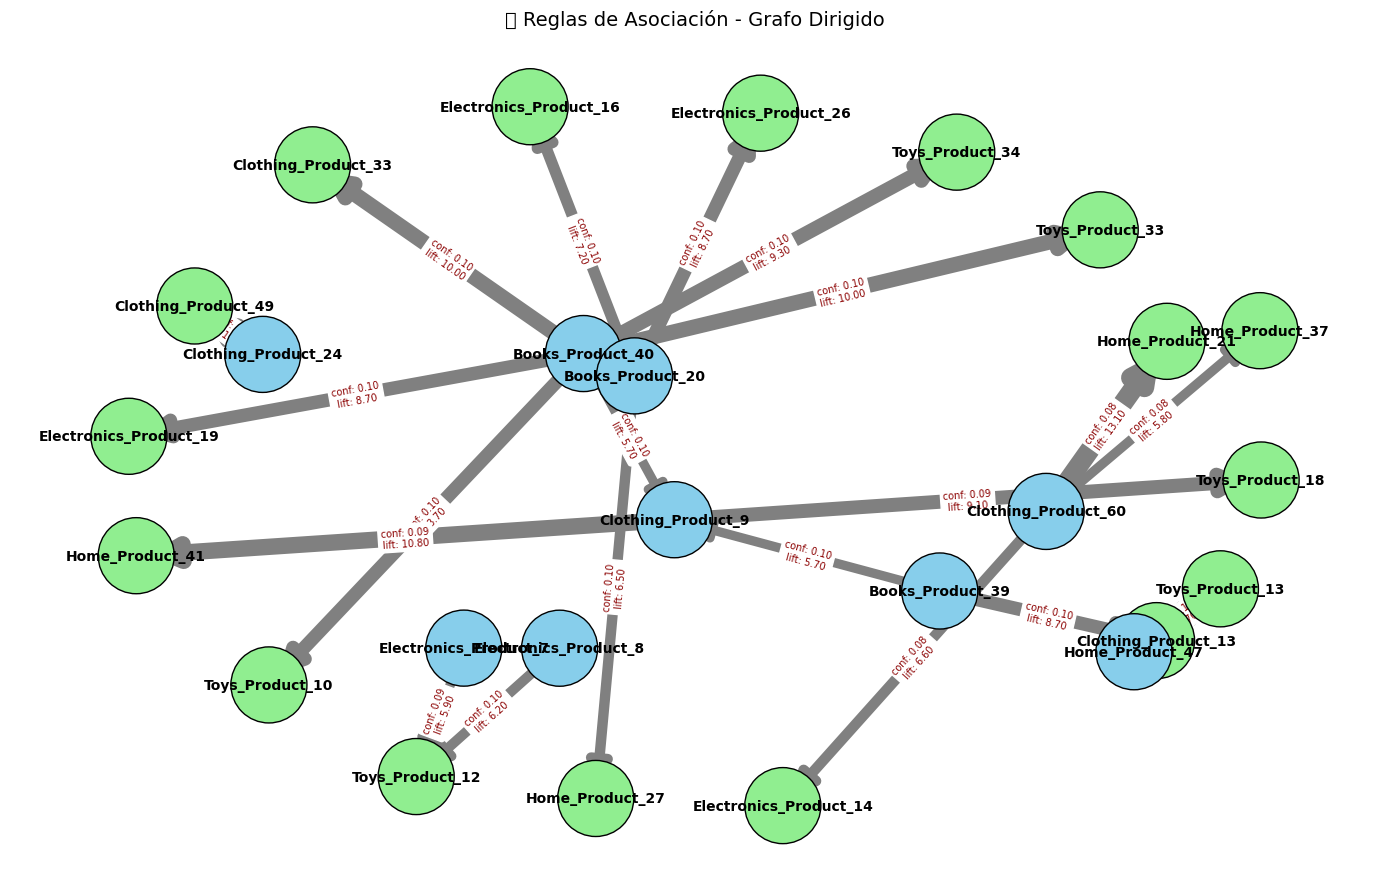

In [135]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_rules_graph(rules):
    G = nx.DiGraph()

    for i in range(len(rules)):
        antecedent = rules["antecedente"].iat[i]
        consequent = rules["consecuente"].iat[i]
        conf = rules["confianza"].iat[i]
        lift = rules["lift"].iat[i]
        label = f"conf: {conf:.2f}\nlift: {lift:.2f}"

        G.add_node(antecedent, color='skyblue')
        G.add_node(consequent, color='lightgreen')
        G.add_edge(antecedent, consequent, label=label, weight=lift)

    # Layout
    pos = nx.spring_layout(G, k=1.2, iterations=100, seed=42)

    # Colores por tipo de nodo
    node_colors = [G.nodes[n]['color'] for n in G.nodes()]
    node_sizes = 3000

    # Dibujar nodos
    plt.figure(figsize=(14, 9))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors='black')
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    # Dibujar aristas con grosor proporcional al lift
    edge_weights = [G[u][v]['weight'] for u,v in G.edges()]
    edges = nx.draw_networkx_edges(
        G, pos,
        edge_color='gray',
        width=[1 + 1*w for w in edge_weights],
        arrows=True,
        arrowsize=30
    )

    # Etiquetas de aristas
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, font_color='darkred')

    # Título
    plt.title('🔗 Reglas de Asociación - Grafo Dirigido', fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Uso:
plot_rules_graph(rules)


## Aca se entiende que cada valor de antecedente podemos recomendar el consecuente como probable para que el cliente lo adquiera. Por ejemplo:

Para Clothing_Product_9 puedo recomendar Toys_Product_18 y Home_Product_41!

In [141]:
antecedente = 'Clothing_Product_9'

mask = rules['antecedente'].map(lambda x: antecedente in x)
rules.loc[mask]

,antecedente,consecuente,soporte_a,confianza,lift,id_producto_a
734,Clothing_Product_9,Toys_Product_18,0.02,0.09,9.1,PROD1059
410,Clothing_Product_9,Home_Product_41,0.02,0.09,10.8,PROD1059


In [142]:
full_order_details.product_name.nunique()

249

## El data frame de transacciones tiene un volumen modesto, para obtener patrones simples.
Pero como sin embargo, si la cantidad de ítems únicos es alta (250), el número de combinaciones posibles es muy grande, por lo que se puede generar muchas reglas con soporte muy bajo y confianza alta espuria, es decir, overfitting.

# Conclusiones

## 📊 Análisis Estratégico para Tienda de Retail Online

Este análisis se centró en proporcionar información estratégica para la toma de decisiones en la tienda de retail online, abordando la rentabilidad de productos, la segmentación de clientes, sus patrones de compra y la identificación de áreas de mejora.

---

### 1. 🛍️ Rentabilidad de Productos y Categorías

#### ▸ Ganancia Bruta vs. Margen de Ganancia
- La categoría **Clothing (Ropa)** genera la **mayor ganancia bruta total** en términos absolutos.
- Sin embargo, la categoría **Home (Hogar)** presenta un **margen de ganancia porcentual ligeramente superior**.
- Se observa una diferencia de aproximadamente **7% en el margen de ganancia** entre los productos más rentables en términos absolutos y los de mayor margen porcentual.

#### ▸ Implicaciones Estratégicas
- **Los productos más rentables en términos absolutos no siempre tienen el mayor margen porcentual.**
- Esto es común: productos con alto volumen de ventas o precios altos generan más ganancia total aun con márgenes moderados.
- **Para maximizar ganancias absolutas**: priorizar productos con alto volumen y/o valor.
- **Para optimizar rentabilidad por unidad**: enfocarse en productos con alto margen.
- Es clave **equilibrar volumen y margen** según la estrategia.

#### ▸ Productos Destacados
Se identificó el **Top 10 de productos** por:
- Ganancia bruta total
- Margen de ganancia porcentual

Esto permite **focalizar acciones de marketing e inventario.**

---

### 2. 👥 Segmentación y Comportamiento de Clientes (RFM)

Se aplicó el modelo **RFM** (Recencia, Frecuencia, Valor Monetario) para segmentar clientes:

#### ▸ Segmentos Identificados

- 🥇 **Clientes Leales (32)**: Alta frecuencia y gasto. Objetivo principal de fidelización.
- 🔥 **Recientes con Alto Potencial (73)**: Compras recientes con buenos valores. Alta oportunidad de retención.
- 🌱 **Buen Potencial (18)**: Compran poco pero gastan mucho. Potencial de crecimiento vía promociones.
- 🚨 **Clientes en Riesgo (25)**: Ex-clientes valiosos inactivos. Requieren reactivación urgente.
- 🧊 **Clientes Perdidos (4)**: Último intento de reactivación podría valer la pena.
- 📉 **Bajo Potencial (88)**: Bajo gasto, frecuencia y recencia. No invertir recursos significativos.

#### ▸ Distribución Geográfica
El análisis muestra la distribución por país, lo que permite ajustar estrategias regionales.

#### ▸ Relación R-F-M
El heatmap de **R_score vs F_score** (coloreado por M_score promedio) confirma que mayor frecuencia suele estar asociada a mayor valor monetario.

---

### 3. 🛒 Patrones de Compra Generales

- **Frecuencia promedio de órdenes por cliente**: `[Insertar order_frequency.mean()]` órdenes.
- **Monto promedio de gasto total por cliente**: `$[Insertar total_spent_per_customer.mean()]`.
- **Valor promedio de un pedido completado**: `$[Insertar avg_order_value]`.

Las distribuciones muestran una concentración de clientes con pocas compras y montos bajos, y una "cola larga" de clientes valiosos. Esto es típico en el comercio minorista(retail).

---

### 4. 🔄 Tasa de Devolución y Rentabilidad

#### ▸ Tasa de Devolución Promedio
- La tasa promedio de devolución es de: `[Insertar valor, ej: 6%]`.

#### ▸ Productos con Alta Devolución
- Se identificaron los **10 productos con mayor tasa de devolución**.


#### ▸ Productos Menos Rentables
- No se encontraron productos con **margen negativo** en pedidos completados, lo cual es positivo.

#### ▸ Tasa de Devolución por Proveedor
- **Supplier_8** y **Supplier_9** tienen tasas de devolución mayores que el promedio.
- Sin embargo, un **test de Kruskal-Wallis** no encontró diferencias significativas.
> No hay evidencia estadística para atribuir mayores devoluciones a proveedores específicos con los datos actuales.

---

### 5. 🔗 Reglas de Asociación (Sistema de Recomendación Básico)

- Se aplicó un análisis de reglas de asociación para detectar productos comprados en conjunto.
- Las transacciones suelen tener **pocos ítems**, lo cual es común.
- Se utilizaron métricas de **soporte mínimo** y **lift** para filtrar reglas útiles.

#### ▸ Ejemplo:
- A partir de **Clothing_Product_9**, se pueden recomendar:
  - `Toys_Product_18`
  - `Home_Product_41`

#### ▸ Limitaciones:
- Con 1300 transacciones y ~250 productos, hay riesgo de **reglas espurias con bajo soporte**.
- Es clave validar reglas antes de usarlas operacionalmente.

---

### ✅ Recomendaciones Generales Accionables

- **📦 Estrategia de Producto Diferenciada**: Balancear promoción de productos de alto volumen vs. alto margen.
- **🤝 Fidelización y Retención Personalizada**: Enfocar esfuerzos en segmentos RFM valiosos.
- **🔍 Investigar Productos con Alta Devolución**: Revisar descripciones, calidad y expectativas.
- **🎯 Optimizar Experiencia del Cliente Nuevo**: Dar excelente primera experiencia para fomentar recompra.
- **🧠 Sistema de Recomendación**: Desarrollar un sistema basado en reglas validadas para aumentar ventas cruzadas.

---



